# Time-Series Analysis
## a similarity analysis between categorical time series


In [3]:
import pandas as pd 
import psycopg2 as pg
import utils.settings_utils as settings
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Get the data

In [4]:
conn = pg.connect(database=settings.get_database(), user=settings.get_user(), password=settings.get_pasword())

In [5]:
def get_data_for_datasetid(datasetid, conn, interval, time='0001-01-01 00:00:00'):
    df = pd.read_sql_query(f"SELECT time AS date, open, high, low, close, volume \
                     FROM stock WHERE identifier = {datasetid} AND time > '{time}' \
                     ORDER BY time ASC;", conn)
    df.set_index(pd.DatetimeIndex(df['date']), inplace=True)
    return resample_data_to_interval(interval, df)

In [6]:
def resample_data_to_interval(interval, df):
    df_d = df.resample(interval).agg(
            {'open': 'first',
            'high': 'max', 
            'low': 'min', 
            'close': 'last', 
            'volume': 'sum'}).dropna()
    df_d.reset_index(inplace=True)
    # df_d = df_d[["date","close"]]

#     df_d["date"] = pd.to_datetime(df_d['date'])
    return df_d

In [7]:
def get_indentifier_for_sub_category(sub_category, conn):
    indentifiers= pd.read_sql_query(f"SELECT identifier, description FROM dataset where secondarycategory = '{sub_category}'", conn)
    indentifiers_list = indentifiers["identifier"].tolist()
    indentifiers_description = indentifiers["description"].tolist()
    return indentifiers_list, indentifiers_description

In [8]:
def get_dataframes(conn, indentifiers):
    df_arr = []
    for i in indentifiers:
        df_arr.append(get_data_for_datasetid(i, conn, 'D', time='2019-01-01 00:00:00'))
    return df_arr

indentifiers, description = get_indentifier_for_sub_category("bank", conn)
df_lst = get_dataframes(conn, indentifiers)
df_lst[0].tail()
# df_lst
# df = get_data_for_datasetid(15611, conn, 'H', time='2000-01-01 00:00:00')


,date,open,high,low,close,volume
496,2022-03-03,10.45,10.80,10.30,10.30,38207.0
497,2022-03-04,10.20,10.30,10.20,10.30,35667.0
498,2022-03-07,10.60,10.60,10.05,10.10,21973.0
499,2022-03-08,10.10,10.35,10.10,10.25,429396.0
500,2022-03-09,10.15,10.45,10.15,10.20,47287.0


IndexError: index 2 is out of bounds for axis 0 with size 2

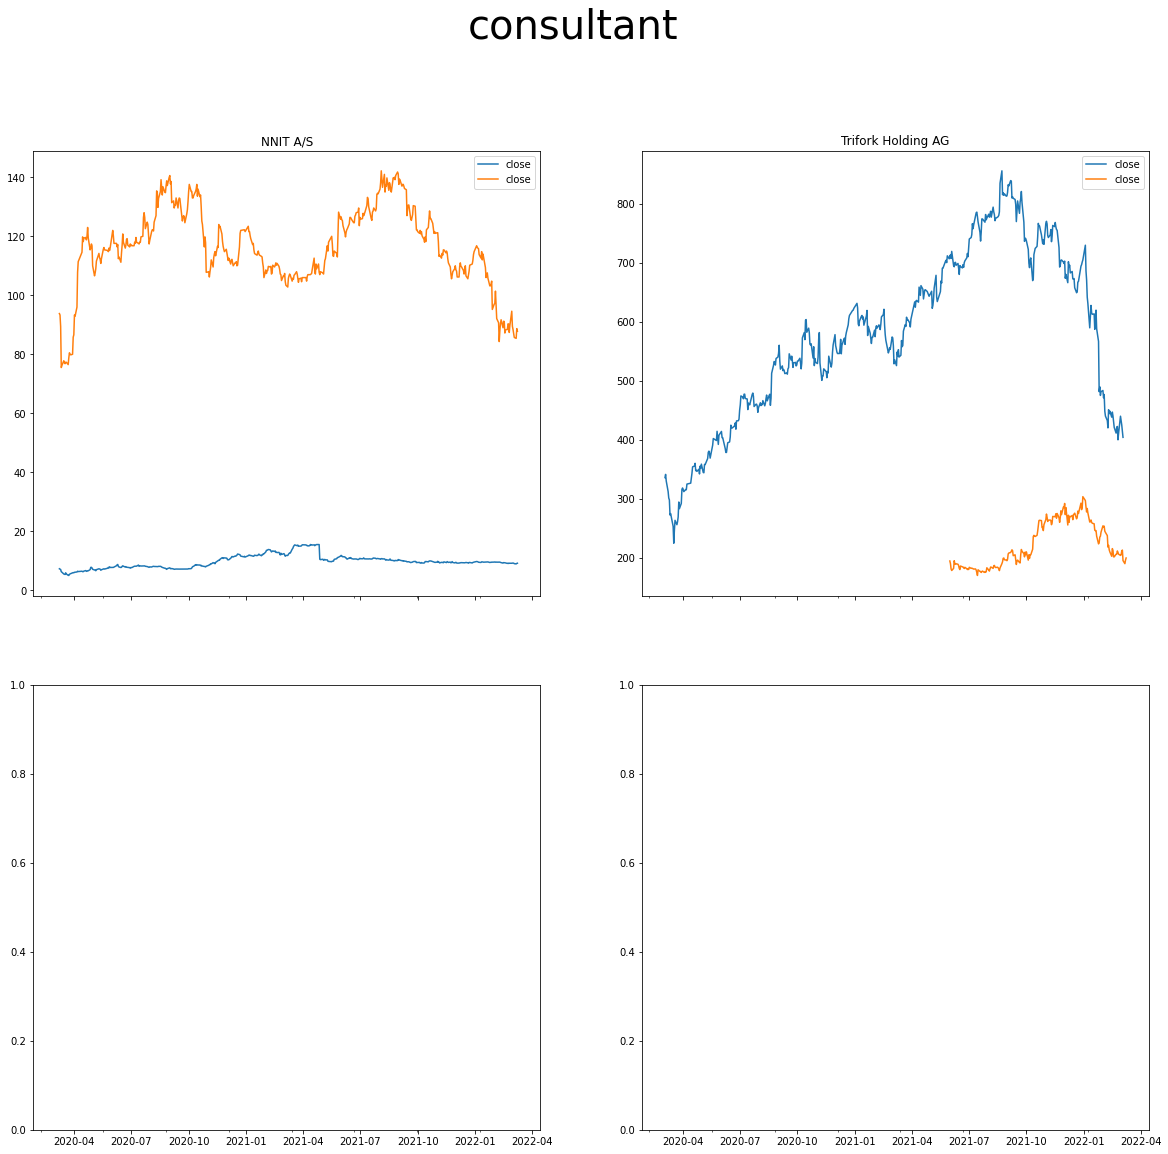

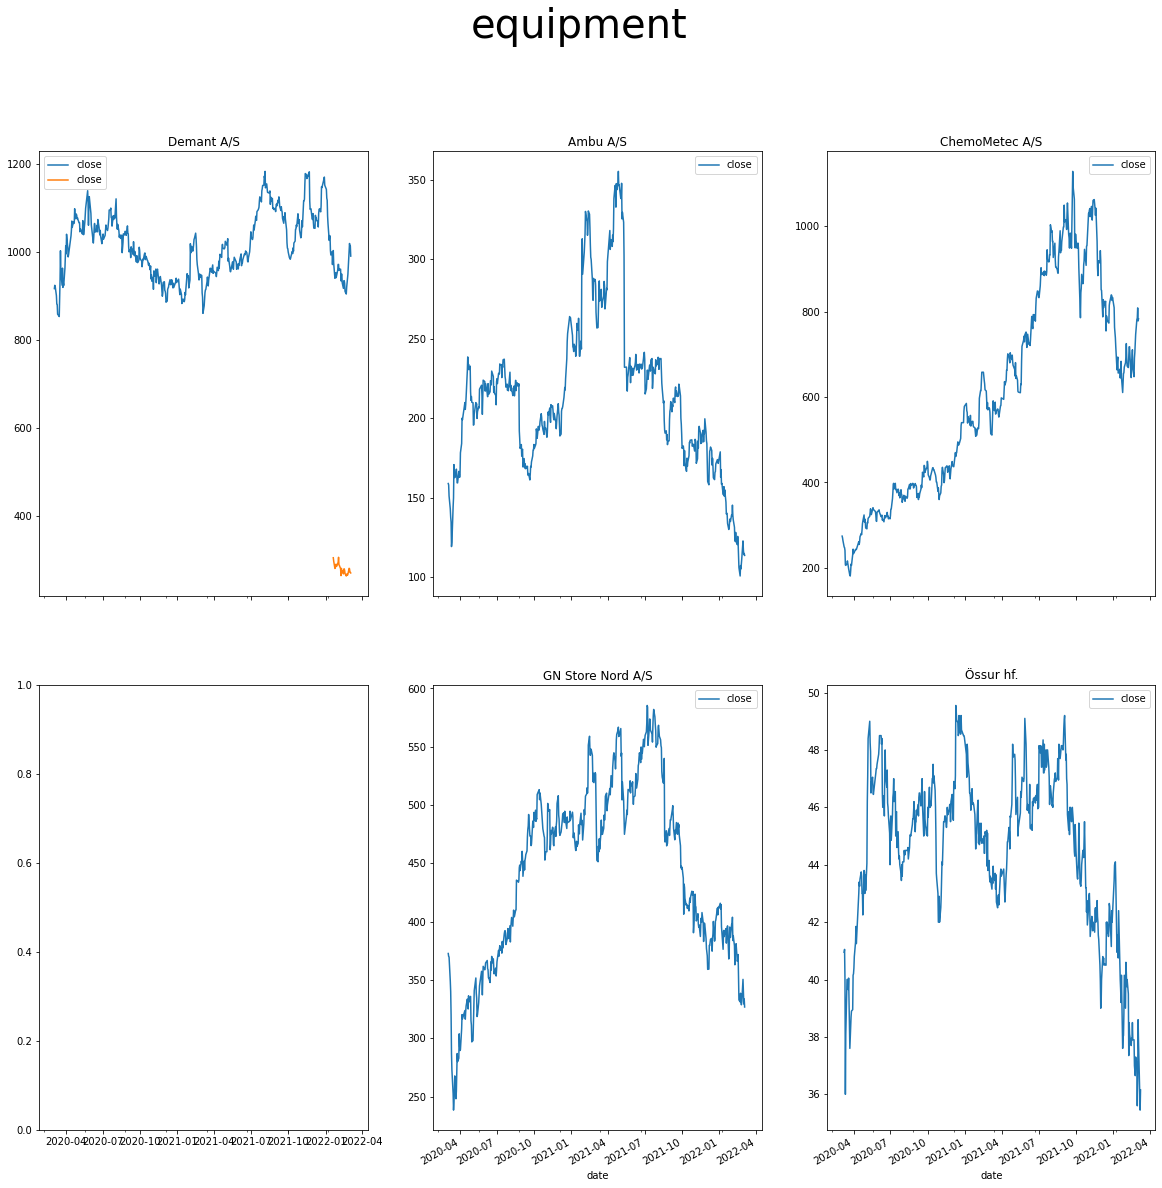

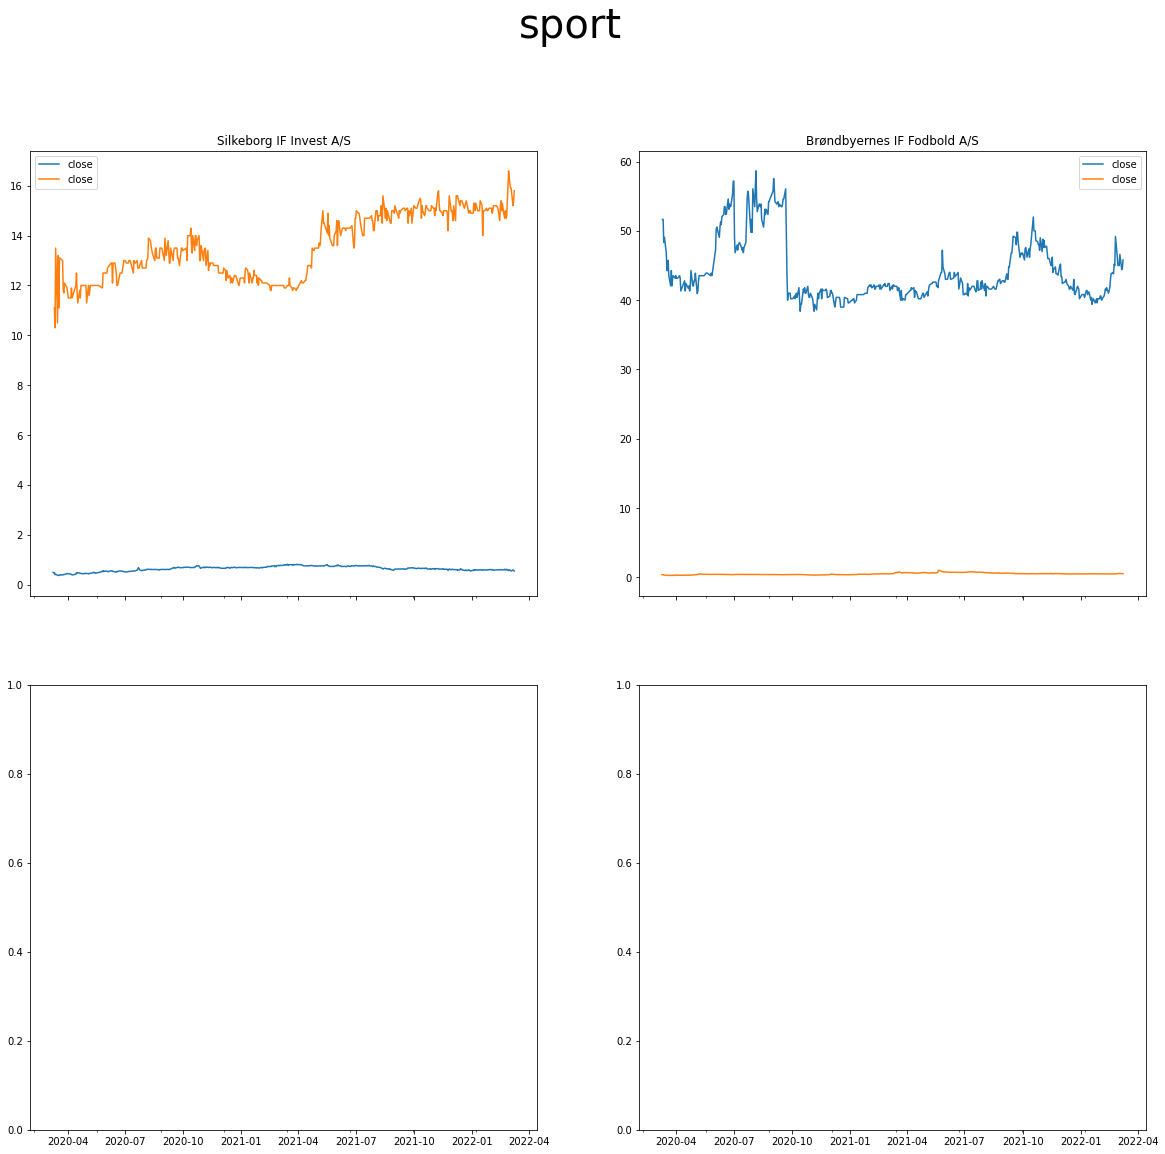

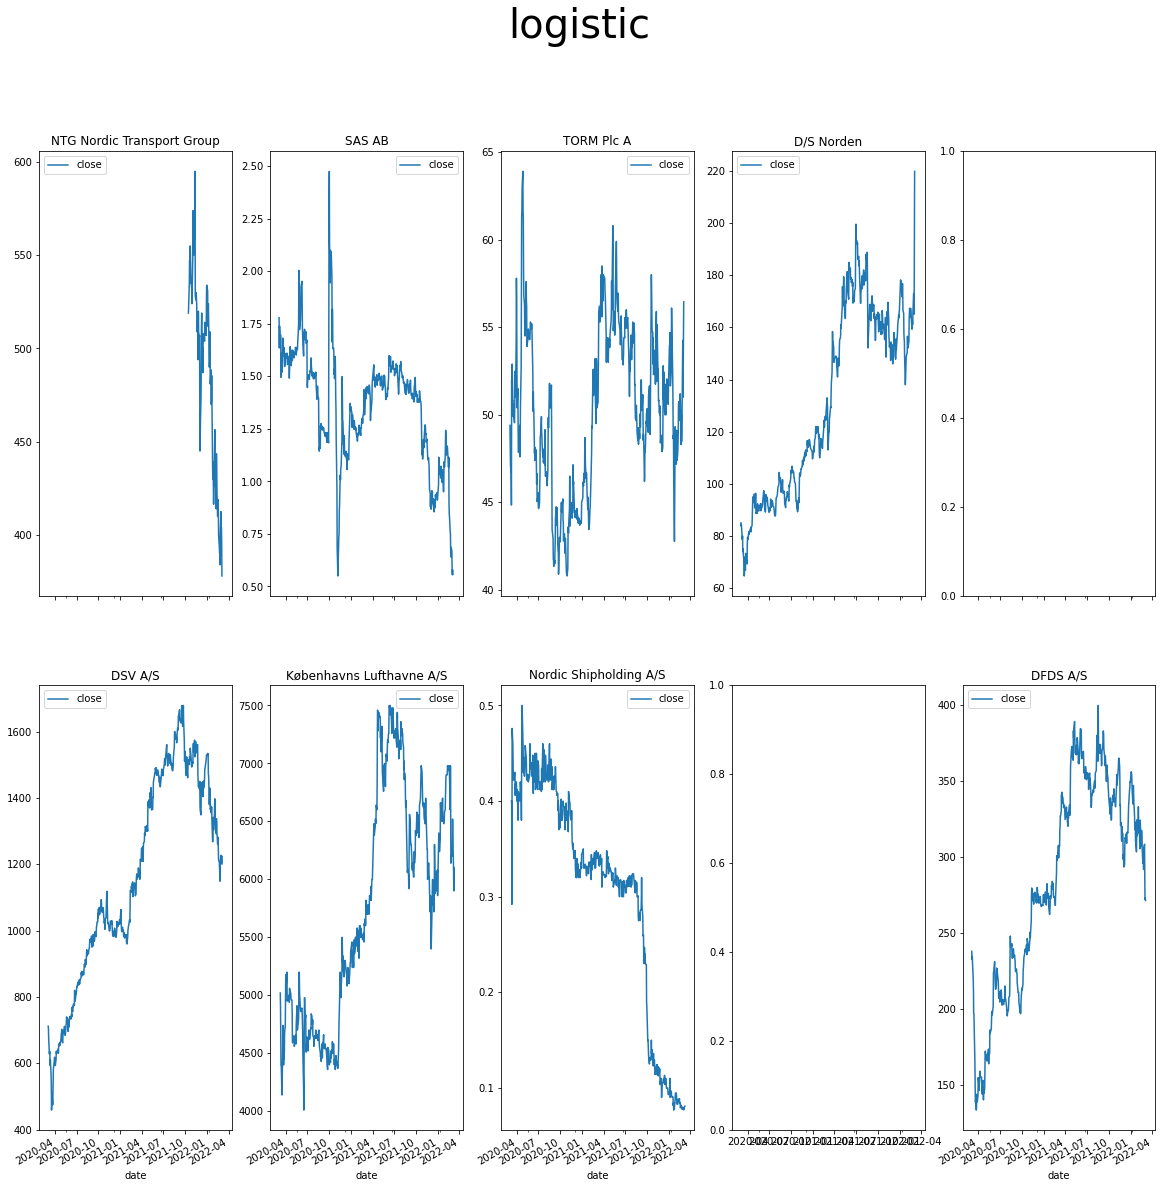

In [17]:
def plot_and_save(sub_lst):
    for sub in sub_lst:
        indentifiers, description = get_indentifier_for_sub_category(sub, conn)
        df_lst = get_dataframes(conn, indentifiers)
        cols = int(len(df_lst)/2)
        fig, axs = plt.subplots(2, cols, figsize=(20, 20), sharex=True)
        fig.suptitle(sub, fontsize=40)
        for i in range(len(df_lst)):
            df_lst[i].plot(x="date", y="close", ax=axs[i//4, i%cols], title=description[i])
        plt.savefig("figures/{}.png".format(sub))
        # for i in range(4):
        #     for j in range(4):
        #         axs[i, j].plot(df_lst[i*4+j]["date"], df_lst[i*4+j]["close"])
        #         axs[i, j].set_title(description[i*4+j])
        #         # axs[i, j].set_xlabel("date")
        #         axs[i, j].set_ylabel("close", rotation=90, labelpad=2)
        #         axs[i,j].set_xticklabels(df_lst[i*4+j]["date"], rotation=15, ha="right", fontsize=10)
        #         axs[i,j].set_yticklabels(df_lst[i*4+j]["close"], fontsize=9, fontname="Arial", fontweight="light", color="black")
        #         plt.savefig("figures/{}.png".format(sub))

sub_lst = get_subcategories(conn)
plot_and_save(sub_lst)

# for each subcategory, plot the data for the last 2 years in a grid and save it as a png file
